In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import pyqg
from time import time
import os
import glob
import cmocean
from pyqg_generative.tools.plot_helpers import *
from pyqg_generative.tools.comparison_tools import dataset_smart_read, dataset_statistics, distrib_score, spectral_score
from pyqg_generative.tools.operators import ave_lev
from pyqg_generative.tools.operators import Operator1, Operator2, PV_subgrid_forcing, ave_lev, coord
from pyqg_generative.tools.parameters import EDDY_PARAMS
from pyqg_generative.tools.spectral_tools import calc_ispec, coord, spectrum
from pyqg_generative.tools.computational_tools import PDF_histogram
from pyqg_generative.tools.simulate import run_simulation
%load_ext autoreload
%autoreload 3

import hvplot.xarray
import holoviews as hv
hvplot.output(widget_location='bottom')

import warnings
warnings.filterwarnings("ignore")

# Idealized ocean model

In [2]:
from dask.diagnostics import ProgressBar
ds = {}
stats = {}
exps = ['64', '128', '256', '512', '1024']
with ProgressBar():
    for res in exps:
        print(res)
        ds['Re_'+res] = dataset_smart_read(f'/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/Re_simulations/res_{res}/[0-9].nc', delta=0.25, compute_all=False, read_cache=True)
        ds[res] = dataset_smart_read(f'/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_{res}/[0-9].nc', delta=0.25, compute_all=False, read_cache=True)
    #    ds[res] = dataset_statistics(f'/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_{res}/[0-9].nc')    
    #    stats[res] = dataset_statistics(ds[res], delta=0.25).compute()

64
128
256
512
1024


In [3]:
# with ProgressBar():
#     ds['1024_9exps'] = dataset_smart_read('/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_1024/no_outlier/*.nc', delta=0.25, compute_all=False, read_cache=True)

In [114]:
default_rcParams()
plt.figure(figsize=(12,12))
for col, res in enumerate(exps):
    plt.subplot(3,3,col+1)
    ds[res].q.isel(time=-1,run=0,lev=0).plot.imshow(cmap=cmocean.cm.balance, add_colorbar=False, interpolation='none')
    plt.gca().axis('off')
    plt.gca().set_aspect(1)
    plt.title(f'${res}\\times{res}$', fontsize=20)
#plt.show()
plt.savefig('Snapshot_resolutions_Re.pdf')

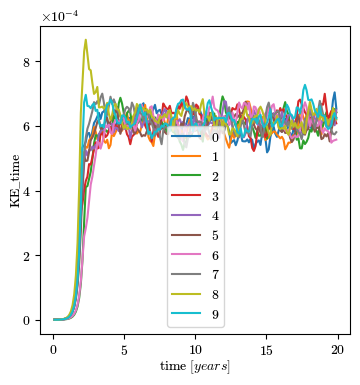

In [120]:
for j, KE in enumerate(ds['1024'].KE_time):
    KE.plot(label=j)
plt.legend()
#plt.yscale('log')
plt.show()

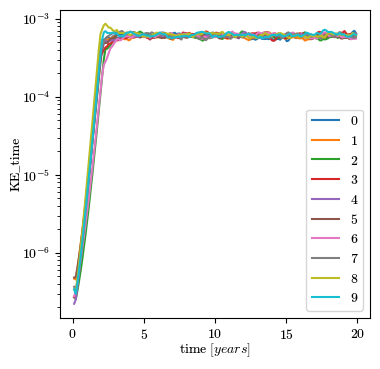

In [124]:
for j, KE in enumerate(ds['1024'].KE_time):
    KE.plot(label=j)
plt.legend()
plt.yscale('log')
plt.show()

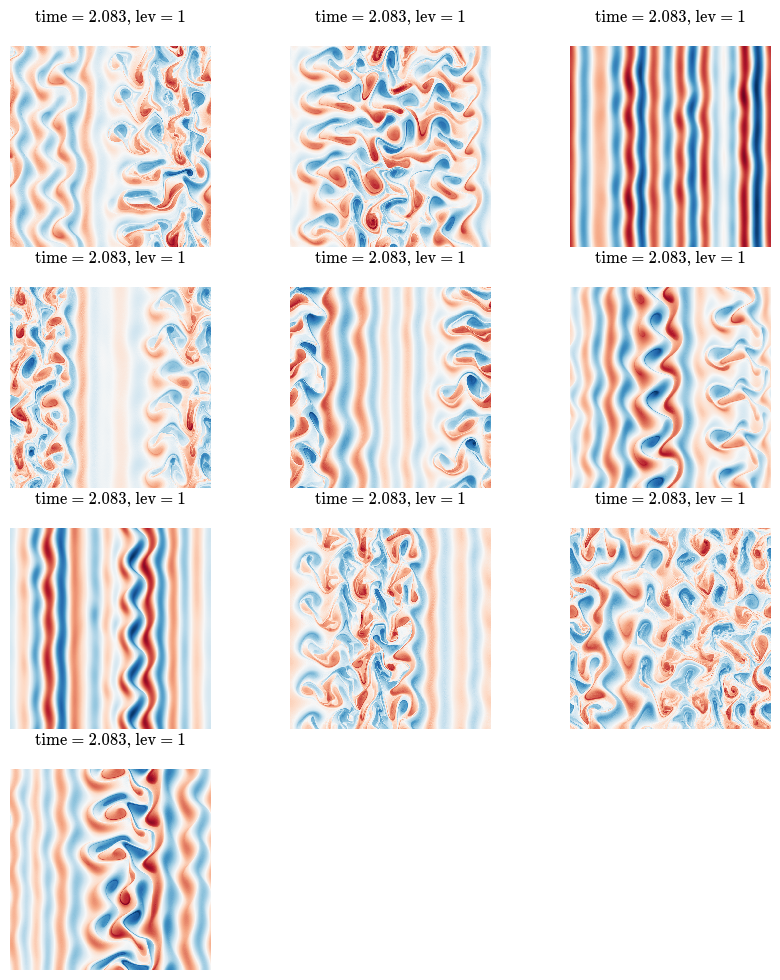

In [123]:
plt.figure(figsize=(10,12))
for run in range(10):
    plt.subplot(4,3,run+1)
    ds['1024'].isel(run=run,time=17,lev=0).q.plot(add_colorbar=False)
    plt.gca().set_aspect(1)
    plt.gca().axis('off')
plt.show()

In [301]:
default_rcParams({'font.size': 16})
plt.figure(figsize=(12,3))
plt.subplot(1,3,1)
colors= ['tab:red', 'tab:green']

(0.5*ds['1024'].KEspecr_mean).plot(ls='-', lw=1,marker='o', markerfacecolor='white', color='k', zorder=1)
(0.5*ds['512'].KEspecr_mean).plot(ls='', marker='x', color=colors[0], zorder=3)
(0.5*ds['256'].KEspecr_mean).plot(ls='', marker='+', color=colors[1], zorder=4)
(0.5*ds['Re_1024'].KEspecr_mean).plot(ls='', marker='o', markerfacecolor='black', markeredgecolor='none', markersize=3, zorder=5)
(0.5*ds['Re_256'].KEspecr_mean).plot(ls='', marker='*', markerfacecolor='black', markeredgecolor='none', markersize=6, zorder=2)
plt.xscale('log')
plt.yscale('log')
plt.ylim([1e-3, 2e+1])
plt.xlim([8e-6,1e-3])
plt.ylabel('KE spectrum, $E(\kappa), m^3/s^2$')

plt.axvspan(0, np.pi/(1e+6/(96*0.65)), color='tab:blue', alpha=0.1, lw=0)
plt.text(1e-5,2e-3,'LES resolved scales', fontsize=12, color='tab:blue')


plt.subplot(1,3,2)
plt.axhline(y=0,color='gray', ls='--')
(ds['1024'].KEfluxr).plot(ls='-', lw=1, marker='o', markerfacecolor='white', color='k', zorder=1)
(ds['512'].KEfluxr).plot(ls='', marker='x', color=colors[0], zorder=3)
(ds['256'].KEfluxr).plot(ls='', marker='+', color=colors[1], zorder=4)
ds['Re_1024'].KEfluxr.plot(ls='', marker='o', markerfacecolor='black', markeredgecolor='none', markersize=3, zorder=5)
ds['Re_256'].KEfluxr.plot(ls='', marker='*', markerfacecolor='black', markeredgecolor='none', markersize=6, zorder=2)
plt.ylim([-4e-6, 4e-6])
plt.xlim([8e-6,1e-3])
plt.xscale('log')
plt.ylabel('KE transfer $m^3/s^3$')
plt.axvspan(0, np.pi/(1e+6/(96*0.65)), color='tab:blue', alpha=0.1, lw=0)

plt.subplot(1,3,3)
plt.axhline(y=0,color='gray', ls='--')
(ds['1024'].APEfluxr).plot(ls='-', lw=1, marker='o', markerfacecolor='white', color='k', label='$1024^2$, exp. filter', zorder=1)
(ds['512'].APEfluxr).plot(ls='', marker='x', label='$512^2$,   exp. filter', color=colors[0], zorder=3)
(ds['256'].APEfluxr).plot(ls='', marker='+', label='$256^2$,   exp. filter', color=colors[1], zorder=4)
ds['Re_1024'].APEfluxr.plot(ls='', marker='o', markerfacecolor='black', markeredgecolor='none', markersize=3, label='$1024^2, Re=64000$', zorder=5)
ds['Re_256'].APEfluxr.plot(ls='', marker='*', markerfacecolor='black', markeredgecolor='none', markersize=6, label='$256^2, ~~  Re=4000$', zorder=2)
plt.ylim([-4e-6, 4e-6])
plt.xlim([8e-6,1e-3])
plt.xscale('log')
plt.ylabel('APE transfer $m^3/s^3$')
plt.axvspan(0, np.pi/(1e+6/(96*0.65)), color='tab:blue', alpha=0.1, lw=0)
#plt.grid()

plt.legend(bbox_to_anchor=(-0.8,-0.5), ncol=2, loc='center')

#plt.show()
plt.savefig('review_figures/Exponential_convergence.pdf')

(1e-08, 20.0)

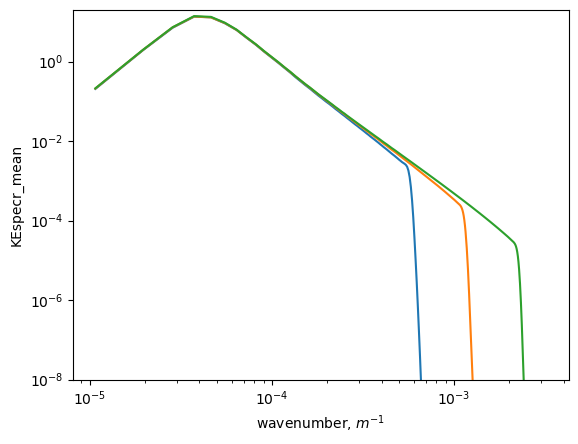

In [9]:
(0.5*ds['256'].KEspecr_mean).plot()
(0.5*ds['512'].KEspecr_mean).plot()
(0.5*ds['1024'].KEspecr_mean).plot()
plt.yscale('log')
plt.xscale('log')
plt.ylim([1e-8,2e+1])

(1e-08, 20.0)

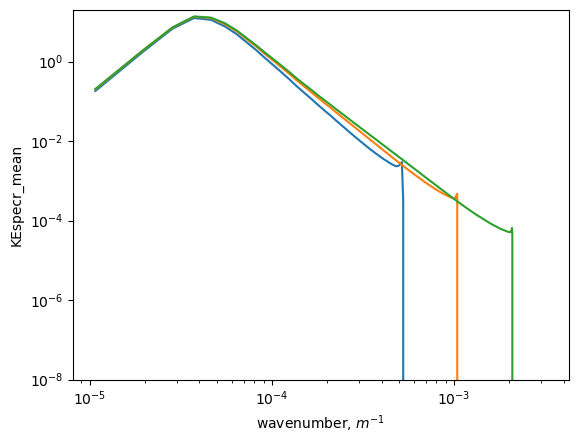

In [10]:
(0.5*ds['Re_256'].KEspecr_mean).plot()
(0.5*ds['Re_512'].KEspecr_mean).plot()
(0.5*ds['Re_1024'].KEspecr_mean).plot()
plt.yscale('log')
plt.xscale('log')
plt.ylim([1e-8,2e+1])

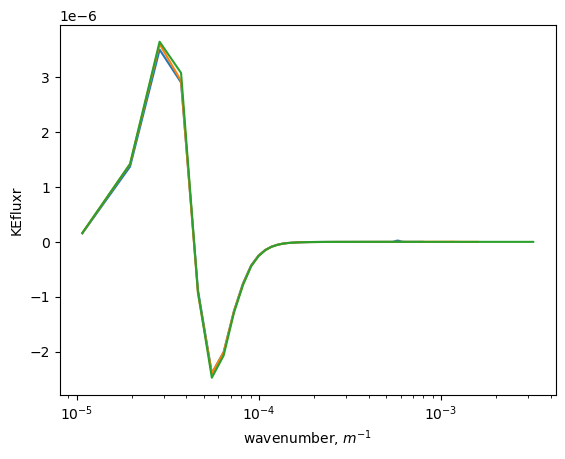

In [12]:
(ds['256'].KEfluxr).plot()
(ds['512'].KEfluxr).plot()
(ds['1024'].KEfluxr).plot()
#plt.yscale('log')
plt.xscale('log')
#plt.ylim([1e-8,2e+1])

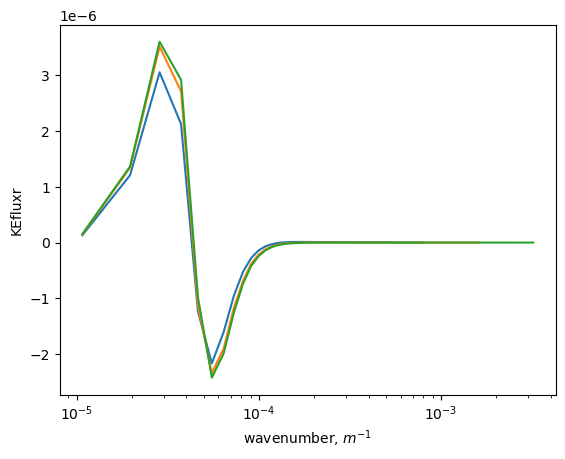

In [13]:
(ds['Re_256'].KEfluxr).plot()
(ds['Re_512'].KEfluxr).plot()
(ds['Re_1024'].KEfluxr).plot()
#plt.yscale('log')
plt.xscale('log')
#plt.ylim([1e-8,2e+1])

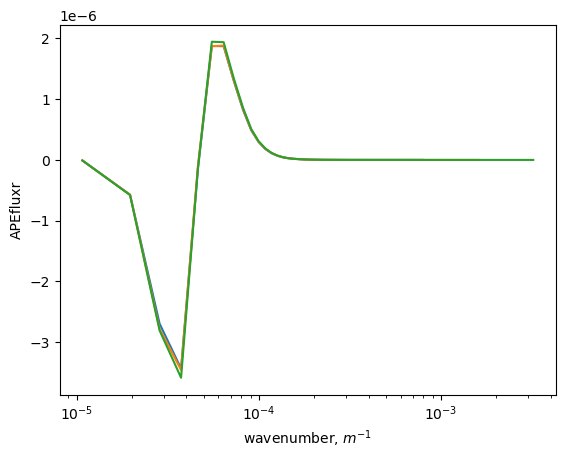

In [14]:
(ds['256'].APEfluxr).plot()
(ds['512'].APEfluxr).plot()
(ds['1024'].APEfluxr).plot()
#plt.yscale('log')
plt.xscale('log')
#plt.ylim([1e-8,2e+1])